## Environment Settings

In [1]:
!pip install -U torch==1.8 torchvision==0.9 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install dominate==2.4.0

!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_dx55b4s
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_dx55b4s
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263921 sha256=e4a986bed747cbbda903ed1c3c6cc4bab8586992d870a4dbe2c67c4449a624c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-36yr5gzp/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
detectron2 0.6+cu101 requires pycocotools>=2.0.2, but you have py

In [2]:
!pip install visdom

     |████████████████████████████████| 676 kB 5.2 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=affcb5407e3811ffc5e0eec6b3bf76de8384b651b241ef6f2fd3ed6e9932f410
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5710 sha256=023f1f8ff92d7ee506bd71618b77e8decda3784906bd47c6d5c74369137fda0d
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built visdom torchfile


In [7]:
#!git clone https://github.com/ericsujw/InstColorization.git
!git clone https://github.com/jaschn/02456_DeepLearningProject.git

fatal: destination path 'DeepLearningProject' already exists and is not an empty directory.


In [8]:
import os
#os.chdir('InstColorization')
os.chdir('DeepLearningProject/InstanceColorization')

In [9]:
!ls

checkpoints	   imgs			   README_TRAIN.md
checkpoints.zip    inference_bbox.py	   Run_training_InstAware.ipynb
data		   InstColorization.ipynb  Run_training_InstAware.py
download.py	   LICENSE		   scripts
env.yml		   models		   test_fusion.py
example		   options		   train.py
fusion_dataset.py  __pycache__		   util
image_util.py	   README.md


## Dataset Preparation (dont run if we have data already)

In [ ]:
# download all coco train dataset (18 gb)
#!sh scripts/prepare_cocostuff.sh

In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# downloading only part of dataset
from os.path import join, isdir
import os
if isdir("train_sample/train2017") is False:
  os.makedirs("train_sample/train2017")
!pip install fastai --upgrade
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

     |████████████████████████████████| 189 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
path = coco_path
    
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


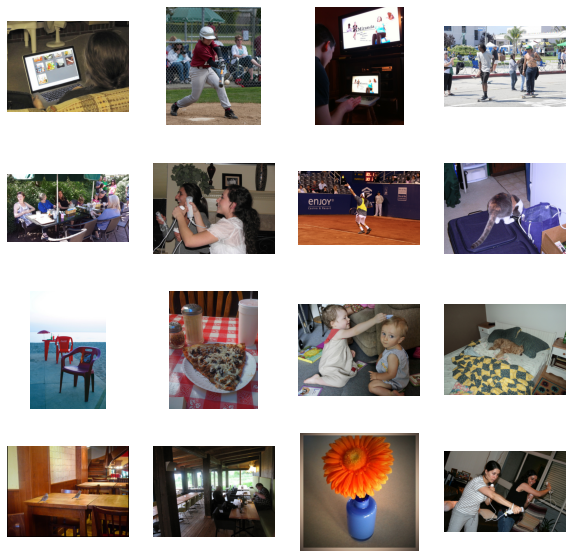

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [ ]:
train_paths[0]

'/root/.fastai/data/coco_sample/train_sample/000000455975.jpg'

In [ ]:
# move images to the train folder
#!mv /root/.fastai/data/coco_sample/train_sample/* train_sample/train2017/
import shutil
for file in train_paths:
  shutil.move(file, 'train_sample/train2017/')

In [ ]:
!ls -1 train_sample/train2017 | wc -l

8000


## Download pretrained model

In [2]:
!sh scripts/download_model.sh

sh: 0: Can't open scripts/download_model.sh


## Instance prediction (dont run if we have data already)

In [ ]:
# or just this
from os.path import join, isfile, isdir
from os import listdir
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from argparse import ArgumentParser

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

import torch
from tqdm import tqdm

cfg = get_cfg()
#cfg.MODEL.DEVICE = 'cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)

input_dir = 'train_sample/train2017'
image_list = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
output_npz_dir = "{0}_bbox".format(input_dir)
if os.path.isdir(output_npz_dir) is False:
    print('Create path: {0}'.format(output_npz_dir))
    os.makedirs(output_npz_dir)

for image_path in tqdm(image_list):
    img = cv2.imread(join(input_dir, image_path))
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_stack = np.stack([l_channel, l_channel, l_channel], axis=2)
    outputs = predictor(l_stack)
    save_path = join(output_npz_dir, image_path.split('.')[0])
    pred_bbox = outputs["instances"].pred_boxes.to(torch.device('cpu')).tensor.numpy()
    pred_scores = outputs["instances"].scores.cpu().data.numpy()
    if pred_bbox.shape[0] == 0:
        print('delete {0}'.format(image_path))
        os.remove(join(input_dir, image_path))
        continue
    np.savez(save_path, bbox = pred_bbox, scores = pred_scores)

Create path: train_sample/train2017_bbox


  5%|▌         | 401/8000 [07:21<1:32:38,  1.37it/s]

delete 000000347648.jpg


  8%|▊         | 627/8000 [10:30<1:36:32,  1.27it/s]

delete 000000096763.jpg


 10%|█         | 826/8000 [13:10<1:28:10,  1.36it/s]

delete 000000422464.jpg


 19%|█▉        | 1518/8000 [21:51<1:20:06,  1.35it/s]

delete 000000484217.jpg


 24%|██▍       | 1923/8000 [27:08<1:14:32,  1.36it/s]

delete 000000074743.jpg


 32%|███▏      | 2537/8000 [34:58<1:10:15,  1.30it/s]

delete 000000220736.jpg


 34%|███▍      | 2729/8000 [37:19<1:04:15,  1.37it/s]

delete 000000033994.jpg


 35%|███▍      | 2797/8000 [38:10<1:05:19,  1.33it/s]

delete 000000465080.jpg


 37%|███▋      | 2934/8000 [39:52<1:00:03,  1.41it/s]

delete 000000129211.jpg


 39%|███▊      | 3091/8000 [41:53<2:31:44,  1.85s/it]

delete 000000532083.jpg


 42%|████▏     | 3369/8000 [45:19<56:32,  1.37it/s]

delete 000000535185.jpg


 45%|████▍     | 3588/8000 [48:00<52:59,  1.39it/s]

delete 000000164496.jpg


 48%|████▊     | 3817/8000 [50:51<52:40,  1.32it/s]

delete 000000274477.jpg


 49%|████▉     | 3900/8000 [51:56<51:20,  1.33it/s]

delete 000000211216.jpg


 56%|█████▌    | 4471/8000 [59:10<43:01,  1.37it/s]

delete 000000251135.jpg


 63%|██████▎   | 5008/8000 [1:05:50<37:29,  1.33it/s]

delete 000000474784.jpg


 64%|██████▍   | 5156/8000 [1:07:40<35:04,  1.35it/s]

delete 000000576549.jpg


 70%|███████   | 5640/8000 [1:13:36<28:13,  1.39it/s]

delete 000000102345.jpg


 71%|███████   | 5680/8000 [1:14:05<28:35,  1.35it/s]

delete 000000331646.jpg


 73%|███████▎  | 5810/8000 [1:15:42<27:05,  1.35it/s]

delete 000000475475.jpg


 73%|███████▎  | 5831/8000 [1:15:57<26:52,  1.35it/s]

delete 000000137733.jpg


 74%|███████▍  | 5953/8000 [1:17:26<25:32,  1.34it/s]

delete 000000057571.jpg


 75%|███████▌  | 6009/8000 [1:18:07<24:16,  1.37it/s]

delete 000000474369.jpg


 77%|███████▋  | 6142/8000 [1:19:45<23:21,  1.33it/s]

delete 000000461844.jpg


 79%|███████▉  | 6346/8000 [1:22:15<20:30,  1.34it/s]

delete 000000085764.jpg


 82%|████████▏ | 6572/8000 [1:25:01<17:21,  1.37it/s]

delete 000000384070.jpg


 84%|████████▎ | 6689/8000 [1:26:26<15:33,  1.40it/s]

delete 000000432119.jpg


 85%|████████▌ | 6805/8000 [1:27:52<14:27,  1.38it/s]

delete 000000339916.jpg


 90%|████████▉ | 7186/8000 [1:32:34<09:55,  1.37it/s]

delete 000000257945.jpg


 92%|█████████▏| 7382/8000 [1:34:59<07:41,  1.34it/s]

delete 000000038561.jpg


 93%|█████████▎| 7458/8000 [1:35:55<06:44,  1.34it/s]

delete 000000264489.jpg


100%|██████████| 8000/8000 [1:42:34<00:00,  1.30it/s]


In [ ]:
# save train_sample
!zip -r train_sample.zip train_sample
from google.colab import files
files.download("train_sample.zip")

## Load train_sample (if you have it on drive)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train the IaIC model

#### check folders

In [ ]:
!ls /content/drive/MyDrive/train_sample/

train2017  train2017_bbox


## Stage 1: Training Full Image Colorization

### train

In [ ]:
# Stage 1: Training Full Image Colorization
!mkdir ./checkpoints/coco_full
!cp ./checkpoints/siggraph_retrained/latest_net_G.pth ./checkpoints/coco_full/
#!python train.py --stage full --name coco_full --sample_p 1.0 --niter 100 --niter_decay 50 --load_model --lr 0.0005 --model train --fineSize 256 --batch_size 16 --display_ncols 3 --display_freq 1600 --print_freq 1600 --train_img_dir train_sample/train2017
!python train.py --stage full --name coco_full --sample_p 1.0 --niter 1 --niter_decay 1 --load_model --lr 0.0005 --model train --fineSize 256 --batch_size 5 --display_ncols 3 --display_freq 1600 --print_freq 1600 --train_img_dir /content/drive/MyDrive/train_sample/train2017

Streaming output truncated to the last 5000 lines.
  File "/usr/local/lib/python3.7/dist-packages/requests/adapters.py", line 516, in send
    raise ConnectionError(e, request=request)
requests.exceptions.ConnectionError: HTTPConnectionPool(host='localhost', port=8098): Max retries exceeded with url: /events (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f3134278b90>: Failed to establish a new connection: [Errno 111] Connection refused'))

batch:  60% 960/1594 [18:13<15:45,  1.49s/it]
batch:  60% 961/1594 [18:14<13:28,  1.28s/it]
batch:  60% 962/1594 [18:15<13:14,  1.26s/it][Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given

batch:  60% 963/1594 [18:16<13:03,  1.24s/it]
batch:  60% 964/1594 [18:17<12:56,  1.23s/it]
batch:  61% 965/1594 [18:19<12:50,  1.23s/it][Errno 99] Cannot assign requested address
on_close() takes 1 positional argument but 3 were given

batch:  61% 966/1594 [18:19<09:20,  1.12it/s]
batc

In [ ]:
!ls checkpoints/coco_full

0_net_G.pth  1_net_G.pth  latest_net_G.pth  loss_log.txt  web


In [ ]:
!ls

checkpoints	   imgs			   README_TRAIN.md
checkpoints.zip    inference_bbox.py	   Run_training_InstAware.ipynb
data		   InstColorization.ipynb  scripts
download.py	   LICENSE		   test_fusion.py
env.yml		   models		   train.py
example		   options		   util
fusion_dataset.py  __pycache__
image_util.py	   README.md


In [ ]:
# save coco_full
!zip -r coco_full.zip checkpoints/coco_full
from google.colab import files
# files.download("coco_full.zip")
import shutil
shutil.move('coco_full.zip', '/content/drive/MyDrive/')

### load from checkpoint

In [4]:
!unzip -u /content/drive/MyDrive/coco_full.zip -d /content/DeepLearningProject/InstanceColorization

Archive:  /content/drive/MyDrive/coco_full.zip


## Stage 2: Training Instance Image Colorization

### train

In [23]:
# Stage 2: Training Instance Image Colorization
!mkdir ./checkpoints/coco_instance1
!cp ./checkpoints/coco_full/latest_net_G.pth ./checkpoints/coco_instance1/
#!python train.py --stage instance --name coco_instance --sample_p 1.0 --niter 100 --niter_decay 50 --load_model --lr 0.0005 --model train --fineSize 256 --batch_size 16 --display_ncols 3 --display_freq 1600 --print_freq 1600 --train_img_dir train_sample/train2017
!python train.py --stage instance --name coco_instance1 --sample_p 1.0 --niter 2 --niter_decay 3 --load_model --lr 0.0005 --model train --fineSize 256 --batch_size 5 --display_ncols 3 --display_freq 1600 --print_freq 1600 --train_img_dir /content/drive/MyDrive/train_sample//train2017


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
#training images = 7969
initialize network with normal
model [TrainModel] was created
loading the model from ./checkpoints/coco_instance1/latest_net_G.pth
Setting up a new session...
Exception in user code:
----------------------------------------------------

In [ ]:
# save coco_instance
!zip -r coco_instance.zip checkpoints/coco_instance
from google.colab import files
# files.download("coco_instance.zip")
import shutil
shutil.move('coco_instance.zip', '/content/drive/MyDrive/')

  adding: checkpoints/coco_instance/ (stored 0%)
  adding: checkpoints/coco_instance/1_net_G.pth (deflated 7%)
  adding: checkpoints/coco_instance/2_net_G.pth (deflated 7%)
  adding: checkpoints/coco_instance/latest_net_G.pth (deflated 7%)
  adding: checkpoints/coco_instance/web/ (stored 0%)
  adding: checkpoints/coco_instance/web/index.html (deflated 93%)
  adding: checkpoints/coco_instance/web/images/ (stored 0%)
  adding: checkpoints/coco_instance/web/images/epoch003_fake_ab_reg.png (stored 0%)
  adding: checkpoints/coco_instance/web/images/epoch000_real.png (deflated 0%)
  adding: checkpoints/coco_instance/web/images/epoch000_fake_ab_reg.png (deflated 0%)
  adding: checkpoints/coco_instance/web/images/epoch000_gray.png (deflated 0%)
  adding: checkpoints/coco_instance/web/images/epoch002_hint.png (deflated 1%)
  adding: checkpoints/coco_instance/web/images/epoch001_fake_reg.png (deflated 0%)
  adding: checkpoints/coco_instance/web/images/epoch003_real_ab.png (stored 0%)
  adding: c

'/content/drive/MyDrive/coco_instance.zip'

### load checkpoint

In [5]:
!unzip -u /content/drive/MyDrive/coco_instance.zip -d /content/DeepLearningProject/InstanceColorization

Archive:  /content/drive/MyDrive/coco_instance.zip


## Stage 3: Training Fusion Module

### train

In [15]:
# Stage 3: Training Fusion Module
!mkdir ./checkpoints/coco_mask
!cp ./checkpoints/coco_full/latest_net_G.pth ./checkpoints/coco_mask/latest_net_GF.pth
!cp ./checkpoints/coco_instance/latest_net_G.pth ./checkpoints/coco_mask/latest_net_G.pth
!cp ./checkpoints/coco_full/latest_net_G.pth ./checkpoints/coco_mask/latest_net_GComp.pth
#!python train.py --stage fusion --name coco_mask --sample_p 1.0 --niter 10 --niter_decay 20 --lr 0.00005 --model train --load_model --display_ncols 4 --fineSize 256 --batch_size 16 --display_freq 500 --print_freq 500 --train_img_dir train_sample/train2017
!python train.py --stage fusion --name coco_mask --sample_p 1.0 --niter 1 --niter_decay 1 --lr 0.00005 --model train --load_model --display_ncols 3 --fineSize 256 --batch_size 5 --display_freq 500 --print_freq 500 --train_img_dir /content/drive/MyDrive/train_sample//train2017

mkdir: cannot create directory ‘./checkpoints/coco_mask’: File exists
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
#training images = 7969
initialize network with normal
initialize network with normal
initialize network with normal
model [TrainModel] was created
loading the model from ./checkpoints/coco

In [ ]:
import time
# from options.train_options import TrainOptions
from models import create_model
from util.visualizer import Visualizer

import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import trange, tqdm

from fusion_dataset import *
from util import util
import os

opt = type('', (), {})()
opt.train_img_dir = '/content/drive/MyDrive/train_sample//train2017'
opt.fineSize = 256
opt.batch_size = 5
opt.loadSize = 256
opt.input_nc = 1
opt.output_nc = 2
opt.ngf = 64
opt.ndf = 64
opt.which_model_netD = 'basic'
opt.which_model_netG = 'siggraph'
opt.n_layers_D = 3
opt.gpu_ids = [0]
opt.dataset_mode = 'aligned'
opt.which_direction = 'AtoB'
opt.nThreads = 4
opt.checkpoints_dir = './checkpoints'
opt.norm = 'batch'
opt.serial_batches = 'store_true'
opt.display_winsize = 256
opt.display_id = 1
opt.display_server = 'http://localhost'
opt.display_port = 8097
opt.no_dropout = False
opt.checkpoints_dir = './checkpoints'
opt.max_dataset_size = float("inf")
opt.resize_or_crop = 'resize_and_crop'
opt.no_flip = False
opt.init_type = 'normal'
opt.verbose = False
opt.suffix = ''
opt.ab_norm = 110
opt.ab_max = 110
opt.ab_quant = 10
opt.l_norm = 100
opt.l_cent = 50
opt.mask_cent = 5
opt.suffix = ''
opt.sample_p = 1.0
opt.sample_Ps = '+'
opt.results_dir = './results/'
opt.classification = False
opt.phase = 'val'
opt.which_epoch = 'latest'
opt.how_many = 200
opt.aspect_ratio = 1.0
opt.load_model = True
opt.half = False
opt.stage = 'fusion'
opt.train_img_dir = '/content/drive/MyDrive/train_sample//train2017'
opt.model = 'train'
opt.name = 'coco_mask'
opt.display_freq = 500
opt.display_ncols = 3
opt.update_html_freq = 10000
opt.print_freq = 500
opt.save_latest_freq = 5000
opt.save_epoch_freq = 1
opt.epoch_count = 0
opt.niter = 1
opt.niter_decay = 1
opt.beta1 = 0.9
opt.lr = 0.00005
opt.no_lsgan = False
opt.lambda_GAN = 0.
opt.lambda_A = 1.
opt.lambda_B = 1.
opt.lambda_identity = 0.5

opt.pool_size = 50
opt.no_html = False
opt.lr_policy = 'lambda'
opt.lr_decay_iters = 50
opt.avg_loss_alpha = .986
opt.isTrain = True


opt.A = 2 * opt.ab_max / opt.ab_quant + 1
opt.B = opt.A

dataset = Training_Fusion_Dataset(opt,1)

dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=True, num_workers=8)

dataset_size = len(dataset)
print('#training images = %d' % dataset_size)

model = create_model(opt)
model.setup(opt)

opt.display_port = 8098
# visualizer = Visualizer(opt)
total_steps = 0

if opt.stage == 'full' or opt.stage == 'instance':
  for epoch in trange(opt.epoch_count, opt.niter + opt.niter_decay, desc='epoch', dynamic_ncols=True):
    epoch_iter = 0

    for data_raw in tqdm(dataset_loader, desc='batch', dynamic_ncols=True, leave=False):
        total_steps += opt.batch_size
        epoch_iter += opt.batch_size

        data_raw['rgb_img'] = [data_raw['rgb_img']]
        data_raw['gray_img'] = [data_raw['gray_img']]

        input_data = util.get_colorization_data(data_raw['gray_img'], opt, p=1.0, ab_thresh=0)
        gt_data = util.get_colorization_data(data_raw['rgb_img'], opt, p=1.0, ab_thresh=10.0)
        if gt_data is None:
            continue
        if(gt_data['B'].shape[0] < opt.batch_size):
            continue
        input_data['B'] = gt_data['B']
        input_data['hint_B'] = gt_data['hint_B']
        input_data['mask_B'] = gt_data['mask_B']

        visualizer.reset()
        model.set_input(input_data)
        model.optimize_parameters()

        if total_steps % opt.display_freq == 0:
            save_result = total_steps % opt.update_html_freq == 0
            # visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

        if total_steps % opt.print_freq == 0:
            losses = model.get_current_losses()
            if opt.display_id > 0:
              ;
                # visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, opt, losses)

    if epoch % opt.save_epoch_freq == 0:
        model.save_networks('latest')
        model.save_networks(epoch)
    model.update_learning_rate()
elif opt.stage == 'fusion':
  for epoch in trange(0, 1 + 1, desc='epoch', dynamic_ncols=True):
    epoch_iter = 0

    for data_raw in tqdm(dataset_loader, desc='batch', dynamic_ncols=True, leave=False):
        total_steps += opt.batch_size
        epoch_iter += opt.batch_size
        print('===========data_row', type(data_raw))
        # data_raw = data_raw[0]
        box_info = data_raw['box_info'][0]
        box_info_2x = data_raw['box_info_2x'][0]
        box_info_4x = data_raw['box_info_4x'][0]
        box_info_8x = data_raw['box_info_8x'][0]
        cropped_input_data = util.get_colorization_data(data_raw['cropped_gray'], opt, p=1.0, ab_thresh=0)
        cropped_gt_data = util.get_colorization_data(data_raw['cropped_rgb'], opt, p=1.0, ab_thresh=10.0)
        full_input_data = util.get_colorization_data(data_raw['full_gray'], opt, p=1.0, ab_thresh=0)
        full_gt_data = util.get_colorization_data(data_raw['full_rgb'], opt, p=1.0, ab_thresh=10.0)
        if cropped_gt_data is None or full_gt_data is None:
            continue
        cropped_input_data['B'] = cropped_gt_data['B']
        full_input_data['B'] = full_gt_data['B']
        # visualizer.reset()
        model.set_input(cropped_input_data)
        model.set_fusion_input(full_input_data, [box_info, box_info_2x, box_info_4x, box_info_8x])
        model.optimize_parameters()

        if total_steps % opt.display_freq == 0:
            save_result = total_steps % opt.update_html_freq == 0
            # visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

        if total_steps % opt.print_freq == 0:
            losses = model.get_current_losses()
            if opt.display_id > 0:
              ;
                # visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, opt, losses)
    if epoch % opt.save_epoch_freq == 0:
        model.save_fusion_epoch(epoch)
    model.update_learning_rate()
else:
  print('Error! Wrong stage selection!')
  exit()


In [30]:
for i in dataset[0].items():
  print()

dict_keys(['cropped_rgb', 'cropped_gray', 'full_rgb', 'full_gray', 'box_info', 'box_info_2x', 'box_info_4x', 'box_info_8x', 'file_id'])

In [ ]:
# save coco_mask
!zip -r coco_mask.zip checkpoints/coco_mask
from google.colab import files
# files.download("coco_mask.zip")
import shutil
shutil.move('coco_mask.zip', '/content/drive/MyDrive/')

### load checkpoint

In [ ]:
!unzip -u /content/drive/MyDrive/coco_mask.zip -d /content/DeepLearningProject/InstanceColorization

## Test

In [ ]:
# 